In [360]:
import numpy as np
import pandas as pd
import json
from os import listdir
import re
from scipy.linalg import eig
import matplotlib.pyplot as plt
from string import ascii_uppercase
import unidecode

In [361]:
def pca(X):
    ''' Principal Components Analysis '''
    cov_matrix = np.cov(X.T) # Transpose b/c np.cov assumes row vars.
    evals, evecs = eig(cov_matrix)
    idcs = np.argsort(evals)[::-1]
    evecs = evecs.real[:, idcs]
    evals = evals.real[idcs]

    return evecs, evals

In [362]:
def preprocess(df):

    old_vals = ['Strongly Disagree',
                'Disagree',
                'Uncertain',
                'Agree',
                'Strongly Agree',
                'No Opinion',
                'Did Not Answer',
                'Did Not Vote',
                'Did not answer',
                None]
    new_vals = [-1.5,
                -1,
                0,
                1,
                1.5,
                np.nan,
                np.nan,
                np.nan,
                np.nan,
                np.nan]

    df = df.replace(old_vals, new_vals)

    # Only retain responders with > 75% response rate
    num_questions = len(df.columns)
    df = df[df.notnull().sum(axis=1) > (num_questions * 0.75)]

    # Replace remaining nans with the column mean
    df = df.fillna(df.mean())

    df = df.sort_index()
    return df

In [363]:
year = '2023'
survey_dir = f'{year}_surveys'

In [364]:
fnames_to_slugs = {

'2023-01-18-US-EEP-Non-Compete-Clauses.csv': 'non-compete-clauses',
'2023-05-09-US-EEP-TikTok.csv': 'tiktok',
'2023-06-21-US-EEP-Junk-Fees.csv': 'junk-fees',
'2023-09-21-US-EEP-AI-and-Market-Power.csv': 'ai-and-market-power',
'2023-09-21-US-EEP-AI-and-the-Labor-Market.csv': 'ai-and-the-labor-market',
'2023-09-29-US-EEP-Subsidizing-Green-Technology.csv': 'subsidizing-green-technology',
'2023-09-29-US-EEP-Responses-To-Market-Power.csv': 'responses-to-market-power',

}



fnames_to_headers = {

'2023-01-18-US-EEP-Non-Compete-Clauses.csv': 'Non-Compete Clauses',
'2023-05-09-US-EEP-TikTok.csv': 'TikTok',
'2023-06-21-US-EEP-Junk-Fees.csv': 'Junk Fees',
'2023-09-21-US-EEP-AI-and-Market-Power.csv': 'AI and Market Power',
'2023-09-21-US-EEP-AI-and-the-Labor-Market.csv': 'AI and the Labor Market',
'2023-09-29-US-EEP-Subsidizing-Green-Technology.csv': 'Subsidizing Green Technology',
'2023-09-29-US-EEP-Responses-To-Market-Power.csv': 'Responses to Market Power',

}

fnames_to_dates = {fname: fname[0:10] for fname in fnames_to_headers.keys()}

In [365]:
fnames_to_dates

{'2023-01-18-US-EEP-Non-Compete-Clauses.csv': '2023-01-18',
 '2023-05-09-US-EEP-TikTok.csv': '2023-05-09',
 '2023-06-21-US-EEP-Junk-Fees.csv': '2023-06-21',
 '2023-09-21-US-EEP-AI-and-Market-Power.csv': '2023-09-21',
 '2023-09-21-US-EEP-AI-and-the-Labor-Market.csv': '2023-09-21',
 '2023-09-29-US-EEP-Subsidizing-Green-Technology.csv': '2023-09-29',
 '2023-09-29-US-EEP-Responses-To-Market-Power.csv': '2023-09-29'}

In [367]:
fnames = sorted(fnames_to_slugs.keys())
fnames = ['2023-06-21-US-EEP-Junk-Fees.csv'] + [fname for fname in fnames if fname != '2023-06-21-US-EEP-Junk-Fees.csv']

qdfs = []
slugs = []
headers = []
dates = []
for fname in fnames:
    qdf = pd.read_csv(survey_dir + '/' + fname)
    qdf = qdf.set_index(qdf['First Name'].str.cat(qdf['Last Name'], sep=' '))
    drop_columns = [col for col in qdf.columns if 'Confidence in this topic' in col or 'Please explain your' in col or 'Unnamed' in col]
    drop_columns += ['First Name', 'Last Name']
    qdf = qdf.drop(columns=drop_columns)
    qdf = qdf[qdf.index.notnull()]
    n_cols = len(qdf.columns)
    if n_cols > 1:
    #     qdf.columns = [f"Part {ascii_uppercase[i]}: {col}" for i, col in enumerate(qdf.columns)]
        qdf.columns = [f"{i+1}. {col}" for i, col in enumerate(qdf.columns)]
    
    qdfs += [qdf]
    for col in qdf.columns:
        slugs += [fnames_to_slugs[fname]]
        headers += [fnames_to_headers[fname]]
        dates += [fnames_to_dates[fname]]

df = pd.concat(qdfs, axis=1)
# df.columns = [f"{i+1}. {col}" for i, col in enumerate(df.columns)]


In [368]:
df = preprocess(df)

In [369]:
X_raw = np.array(df).astype(float)
q_means = X_raw.mean(axis=0)
q_sds = X_raw.std(axis=0)

In [370]:
# Separate responder IDs from row names
responder_ids = list(range(len(df)))

# Compute +/- 2SD for each question. For yellow highlights.
X_raw = np.array(df).astype(float)
q_means = X_raw.mean(axis=0)
q_sds = X_raw.std(axis=0)
igm_top_range =    2 * q_sds # Responses will be centered with q_means in .js
igm_bot_range = (-2) * q_sds # Responses will be centered with q_means in .js

# Centering the questions
X = X_raw - X_raw.mean(axis=0)

# Run PCA and compute 2D projection
evecs, evals = pca(X)

In [371]:
if year in ('2021', '2023'):
    evecs[:,1] = evecs[:,1] #X
    evecs[:,0] = -evecs[:,0]
    print('hi')
    
# Compute each economists projection in 2D space.
proj = np.dot(X, evecs[:, 0:2])

# Sign flipping so politically left is on the left


# User info dict
user_info = {'name': 'You',
             'x': 0,
             'y': 0,
             'responder_id': 0}

hi


In [372]:
# Get correlation matrix, sorted by position on x-axis.
pc1_order = np.argsort(proj[:, 0])
corr_mat = np.corrcoef(X_raw[pc1_order, :])

# List of responder info dicts, including user dict
points = [user_info]
assert(len(df)==len(proj))
for i in range(len(proj)):
    responder_info = {'name': df.index[i],
                      'x': proj[i, 0],
                      'y': proj[i, 1],
                      'short_name': unidecode.unidecode(df.index[i].lower().replace(' ', '-')),
                      'pc1_order': int(np.argwhere(pc1_order == i))}
    points.append(responder_info)

In [373]:
out = {}
out['points'] = points
out['q_slugs'] = slugs
out['q_headers'] = headers
out['q_dates'] = dates
out['questions'] = [re.sub(r"\(0+", "(", col) for col in df.columns]
out['q_means'] = list(q_means)
out['xweights'] = list(evecs[:, 0])
out['yweights'] = list(evecs[:, 1])
out['X'] = [['%.2f' % el for el in row] for row in X.tolist()]
out['corr_mat'] = [['%.2f' % el for el in row]
                   for row in corr_mat.tolist()]
out['igm_top_range'] = ['%.2f' % el for el in igm_top_range]
out['igm_bot_range'] = ['%.2f' % el for el in igm_bot_range]

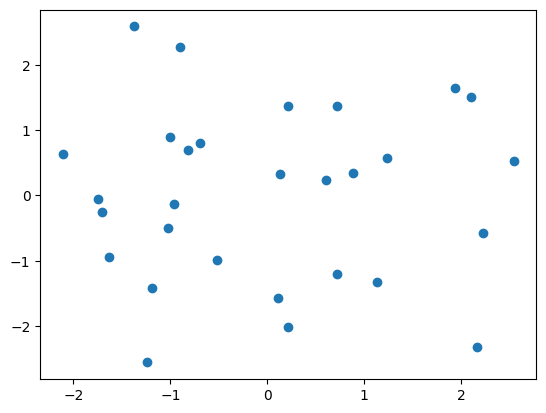

In [374]:
# Write to file
f = open("pca_results_" + year + ".json", "w")
json.dump(out, f, indent=2)
f.close()

# Plot responders in 2D space
plt.figure()
plt.scatter(proj[:, 0], proj[:, 1])
plt.show()

In [375]:
len(out['q_headers']), len(out['questions'])

(19, 19)

In [ ]:
out['questions']

In [376]:
out['q_dates']

['2023-06-21',
 '2023-06-21',
 '2023-06-21',
 '2023-01-18',
 '2023-01-18',
 '2023-01-18',
 '2023-05-09',
 '2023-05-09',
 '2023-09-21',
 '2023-09-21',
 '2023-09-21',
 '2023-09-21',
 '2023-09-21',
 '2023-09-21',
 '2023-09-29',
 '2023-09-29',
 '2023-09-29',
 '2023-09-29',
 '2023-09-29']